# TP 2 : Computer Vision

## Part 2 : feature detection

In this part of the TP, we are going to look at the following feature detector :

- Harris corner detection

First, let us again load some packages and define some helper functions

--2021-12-09 20:29:24--  https://perso.telecom-paristech.fr/anewson/doc/images/mit.png
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 816602 (797K) [image/png]
Saving to: ‘mit.png’

mit.png             100%[===================>] 797.46K  2.14MB/s    in 0.4s    

2021-12-09 20:29:25 (2.14 MB/s) - ‘mit.png’ saved [816602/816602]



(600, 800)

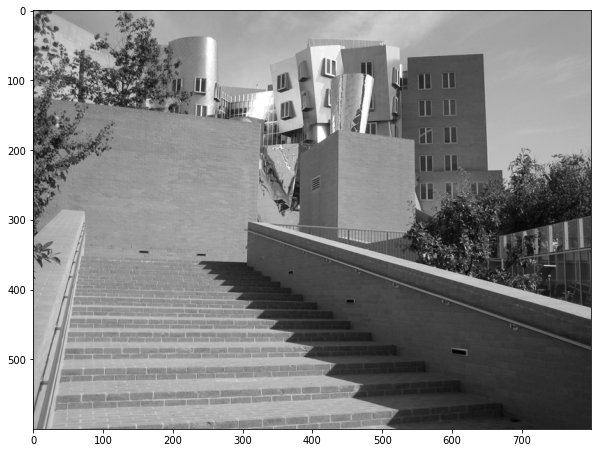

In [1]:
from matplotlib import pyplot as plt
import numpy as np 
import imageio
from skimage import color
from scipy import signal
from scipy.ndimage.morphology import binary_dilation

is_colab = True

def read_image(file_name):
    img_color = imageio.imread(file_name)
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))
    
def display_image(img_in):
    plt.figure(figsize=(10, 10))
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return

# this function annotates an image with coloured squares at the positions detected by the harris detector
def annotate_image(img_in, img_harris):
    
    img_harris_out = np.tile( np.expand_dims(img_in,axis=2), (1,1,3))
    block_size = 5
    struct_el = np.ones((block_size,block_size))
    # now annotate the image
    img_harris = binary_dilation(img_harris,struct_el)
    img_harris_out[img_harris>0,0] = 1.0
    img_harris_out[img_harris>0,1:3] = 0.0
    
        
    return img_harris_out


file_dir = 'images/'
file_name = 'mit'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/mit.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)

display_image(img_gray)
img_gray.shape

The goal of the Harris detector is to detect corners. The criterion used is the following : if we shift the image (spatially) in any direction, the underlying image should change values. In other words, we should be able to distinguish between the initial image and the shifted image. This is not true, for example, with constant images or edges; there is an ambiguity (see the lesson slides for more detail).

This criterion is formalised by associating the following matrix with __each pixel__ $p$ in the image :

$A = 
    \begin{bmatrix}
        \sum_{q \in \Psi_p} I_x(q)^2 & \sum_{q \in \Psi_p} I_x(q)I_y(q) \\
        \sum_{q \in \Psi_p} I_x(q)I_y(q) & \sum_{q \in \Psi_p} I_y(q)^2
    \end{bmatrix}
$

where $I_x$ is the $x$-direction component of image gradient, and similarly for $I_y$, and $\Psi_p$ is a small ''patch'' centred on $p$. A patch is a small image square.

Each pixel, therefore, contains a descriptor. The Harris detector consists in detecting the pixels whose descriptor verifies the following criterion :

$| \text{det}(A) - \alpha \text{trace}(A)^2 |  >k$

where det refers to the determinant of the matrix, and $k$ is a threshold. If this criterion is verified, then both the eigenvalues of the matrix are very large, which means that the two principal directions of local motion in the image lead to large changes in the image (which is what we were looking for). In fact, this does not correspond to __only__ corners, however corners do verify this criterion. 

For more precise details about this, again, see the slides.

We are going to implement this detector now.

Firstly, implement a function ``harris_feature`` which calculates the previous criterion for each pixel. You will have to implement the following steps :

- calculate the necessar gradients (you can use the ``np.gradient`` function) 
- create a filter to calculate the sum of the different gradients in a patch region. You should calculate these sums __before__ carrying out the two loops over the pixels, to avoid inefficient computation
- for each pixel, create the matrix $A$ and determine the Harris feature. For the matrix operations, you can use the ``np.linalg`` subpackage
- threshold the resulting image


Use the following parameters :

- patch_size = 7
- $\alpha$ = 0.04
- $k$ = 0.048

In [2]:
def harris_feature(img,k,alpha):
  # FILL IN HERE:
  patch_size = 7
  Ix,Iy=np.gradient(img)
  Ix_x = Ix**2
  Iy_y = Iy**2
  Ix_y = Ix*Iy

  psi=np.ones((patch_size,patch_size))

  av_xx = signal.convolve2d(Ix_x,psi, mode='same')
  av_yy = signal.convolve2d(Iy_y,psi, mode='same')
  av_xy = signal.convolve2d(Ix_y,psi, mode='same')

  img_harris_detect=np.zeros(img.shape)
  n,m=img.shape
  for i in range(n):
    for j in range(m):
      A=np.array([[av_xx[i,j],av_xy[i,j]],[av_xy[i,j],av_yy[i,j]]])
      det = np.linalg.det(A)
      trace = np.trace(A)
      crit = np.abs(det - alpha*trace**2)
      img_harris_detect[i,j] = k*int(crit>k)

  return img_harris_detect

Now, display the resulting image. You can use the function ``annotate_image``. Note, this outputs and RGB image, where the detected points are annotated as blocks of a certain size (5 here), in red. To display this image, you need to put the pixel values back to the range $0, \dots, 255$

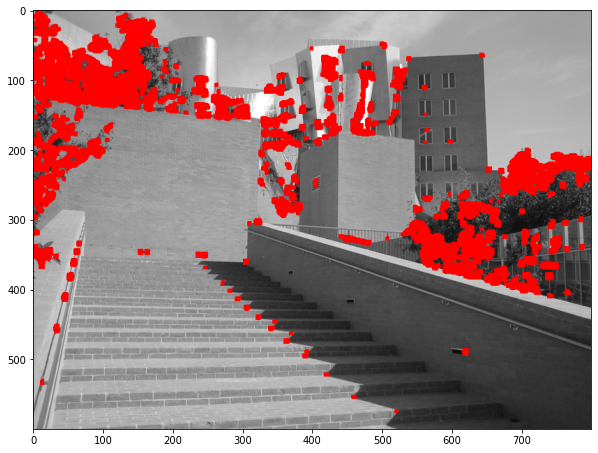

In [3]:
alpha = 0.04
k = 0.048
img_harris = harris_feature(img_gray,k,alpha) # FILL IN HERE
display_image(255.0*annotate_image(img_gray,img_harris))

Now, you should observe something here: regions with many detections. Therefore, there is a second step : non-maximum suppression. This simply corresponds to removing detected pixels for which the Harris feature is not the maximum in a certain region.

Copy and paste the ``harris_feature`` code, and include non-maximum suppression before the output. For this, the following function can be useful:

- scipy.ndimage.maximum_filter()

In [4]:
from scipy.ndimage import maximum_filter
def harris_feature(img,k,alpha):
  # FILL IN HERE:
  patch_size = 7
  Ix,Iy=np.gradient(img)
  Ix_x = Ix**2
  Iy_y = Iy**2
  Ix_y = Ix*Iy

  psi=np.ones((patch_size,patch_size))

  av_xx = signal.convolve2d(Ix_x,psi, mode='same')
  av_yy = signal.convolve2d(Iy_y,psi, mode='same')
  av_xy = signal.convolve2d(Ix_y,psi, mode='same')

  img_harris_detect=np.zeros(img.shape)
  n,m=img.shape
  for i in range(n):
    for j in range(m):
      A=np.array([[av_xx[i,j],av_xy[i,j]],[av_xy[i,j],av_yy[i,j]]])
      det = np.linalg.det(A)
      trace = np.trace(A)
      crit = np.abs(det - alpha*trace**2)
      img_harris_detect[i,j] = crit*int(crit>k)
  img_harris_detect_nms = maximum_filter(img_harris_detect,size=patch_size) 
  img_harris_detect[img_harris_detect_nms != img_harris_detect] = 0
  return img_harris_detect

Carry out the algorithm and display the result

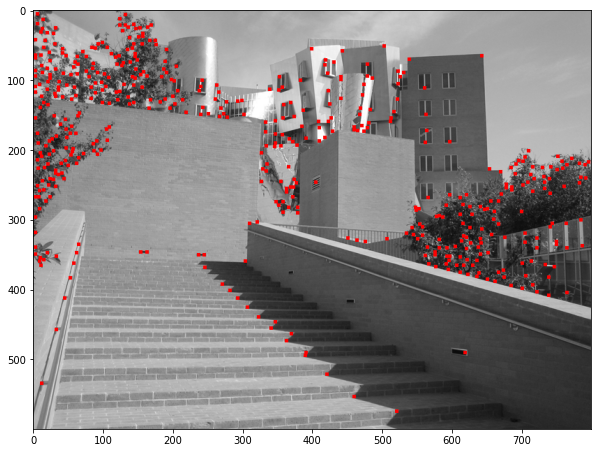

In [5]:
alpha = 0.04
k = 0.048
img_harris = harris_feature(img_gray,k,alpha)
display_image(255.0*annotate_image(img_gray,img_harris))

__Question 2.1__ Are there any corners missed ? Why do you think this is ? What solution could you propose (which we have seen in the first lesson) to improve the result.

__Answer__ Yes there are some corners that are missed. For example, the corners of the bricks of the stairs were not detected. This issue is due to low contrast in the image. We can solve this problem as we did in the previous lab by using histogram equalization method in order to have better contrast in the image and detect the missed corners.

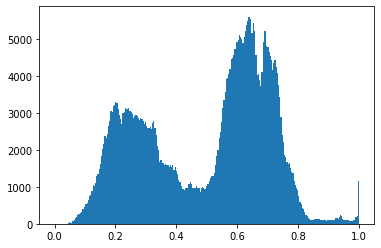

In [6]:
Hist = plt.hist(img_gray.flatten(), bins=np.linspace(0,1,257))

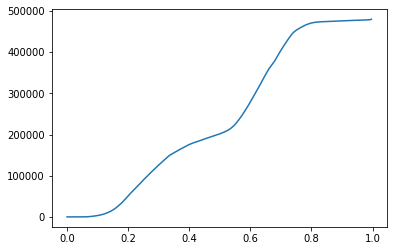

In [7]:
cum_hist=np.cumsum(Hist[0])
plt.plot(Hist[1][:-1],cum_hist)

In [8]:
def equalize_histogram(img_in):
    # FILL IN CODE
    Hist,_ = np.histogram(img_in.flatten(), bins=np.linspace(0,1,257))
    H=np.cumsum(Hist)
    #normalizing the cumulative histogram
    H=(H-np.min(H))/(np.max(H)-np.min(H))
    img_equalise=img_in.copy()
    img_equalise=255*img_equalise
    n,m=img_equalise.shape
    for i in range(n):
      for j in range(m):
        img_equalise[i,j]=H[int(img_equalise[i,j])]
    return img_equalise

In [9]:
img_gray_equalise = equalize_histogram(img_gray)

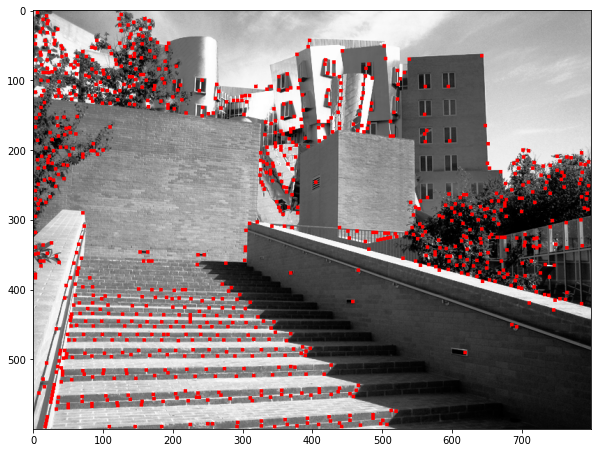

In [10]:
img_harris_equalise = harris_feature(img_gray_equalise,k,alpha)
display_image(255.0*annotate_image(img_gray_equalise,img_harris_equalise))